<a href="https://colab.research.google.com/github/bgmseo/MotGen/blob/main/generatemotility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_printoptions(sci_mode=False)
batch_size = 128
workers = 0

In [ ]:
### class needed before model called
latent_dim = 100
output_dim = 10
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n = 300
        self.l1 = nn.Linear(latent_dim+2,n)
        self.l2 = nn.Linear(n,n)
        self.l3 = nn.Linear(n,n)
        self.l4 = nn.Linear(n,n)
        self.l5 = nn.Linear(n,n)
        self.l6 = nn.Linear(n,n)
        self.l7 = nn.Linear(n,n)
        self.l8 = nn.Linear(n,n)
        self.l9 = nn.Linear(n,output_dim)
        self.activation = nn.LeakyReLU(negative_slope=0.1)

        self.bn2 = nn.BatchNorm1d(n)
        self.bn3 = nn.BatchNorm1d(n)
        self.bn4 = nn.BatchNorm1d(n)
        self.bn5 = nn.BatchNorm1d(n)
        self.bn6 = nn.BatchNorm1d(n)
        self.bn7 = nn.BatchNorm1d(n)
        self.bn8 = nn.BatchNorm1d(n)

    def forward(self, x):
        x = x.view(-1, latent_dim+2)
        x = self.activation(self.l1(x))
        x = self.bn2(self.activation(self.l2(x)))
        x = self.bn3(self.activation(self.l3(x)))
        x = self.bn4(self.activation(self.l4(x)))
        x = self.bn5(self.activation(self.l5(x)))
        x = self.bn6(self.activation(self.l6(x)))
        x = self.bn7(self.activation(self.l7(x)))
        x = self.bn8(self.activation(self.l8(x)))
        return self.l9(x)



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n = 300
        self.l1 = nn.Linear(output_dim+2,n)
        self.l2 = nn.Linear(n,n)
        self.l3 = nn.Linear(n,n)
        self.l4 = nn.Linear(n,n)
        self.l5 = nn.Linear(n,n)
        self.l6 = nn.Linear(n,n)
        self.l7 = nn.Linear(n,n)
        self.l8 = nn.Linear(n,n)
        self.l9 = nn.Linear(n,1)
        self.activation = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):
        x = self.activation(self.l1(x))
        x = self.activation(self.l2(x))
        x = self.activation(self.l3(x))
        x = self.activation(self.l4(x))
        x = self.activation(self.l5(x))
        x = self.activation(self.l6(x))
#         x = self.activation(self.l7(x))
#         x = self.activation(self.l8(x))
        return torch.sigmoid(self.l9(x))


In [ ]:
# G = torch.load('./models/GGG_final')
# D = torch.load('./models/DDD_final')
# G.eval()
# D.eval()

In [ ]:
#Environmental settings (Must be laoded)
env_map2 = torch.load('./env_map2')

In [ ]:
x, y = np.meshgrid([25, 37, 45], [5,6,7,8])
x3 = np.mat([[6.5, 6.9],[35, 27]])

env_map = np.zeros([12,2])

env_map[:,0] = y.reshape(-1)  # PH in 1st column
env_map[:,1] = x.reshape(-1)  # degree in 2nd column

env_mapT = np.zeros([2,2])
env_mapT[:,0] = x3[0,:].reshape(-1)  # PH in 1st column
env_mapT[:,1] = x3[1,:].reshape(-1)  # degree in 2nd column


In [ ]:
# print(files)

In [ ]:
## Loading verification data
root_path = './data/test'
files = [dI for dI in os.listdir(root_path) if os.path.isfile(os.path.join(root_path, dI))]

N = len(files)

activity_data = list()
env_data = list()


for i in range(N):
    matrix = np.loadtxt(root_path + '/' + files[i], delimiter=',') # load data txt for each experiment
    num_all = len(matrix) # number of all detected bacterias

    mov_idx = matrix[:, 8] == 1            # moving index
    num_moving = mov_idx.sum()             # number of moving bacterias
    mov_ratio = num_moving / num_all       # moving ratio
    matrix = matrix[mov_idx, :]            # eliminating static bacterias
    matrix[:, 8] = mov_ratio               # using moving ratio as input instead of moving index

    matrix = matrix[:,[0,1,2,3,4,5,6,7,9,10]]  # 8th column excluded

    activity_data.append(torch.Tensor(matrix))

    env_matrix = np.zeros([num_moving, 2])

    if int(files[i][1:3]) == "69":
        env_matrix[:]=env_mapT[0]
    else :
        env_matrix[:]=env_mapT[1]

    env_data.append(torch.Tensor(env_matrix))
env_data = torch.cat(env_data).to(device)
activity_data = torch.cat(activity_data).to(device)

dataset = torch.cat([env_data,activity_data],dim=1)

print(dataset.mean(axis=0))


tensor([  6.9000,  27.0000,  35.3008, 117.3082, 171.9520,  30.4736,   0.2668,
         18.0243,  11.3222,   0.4085,  28.0683, 204.7236], device='cuda:0')
torch.Size([744, 10])


In [ ]:
# normalize
def solvex(x,u,s):
    output = ((x-u)/s)
    return output

#  denormalization
def invsolve(x,u,s):
    element = (x*s)+u
    return element

Generate data in specific envrionmental conditions

In [ ]:
### Create test data
env_np = env_map2
raw2 = torch.tensor([4.3])
raw3 = torch.tensor([36.9])

x = solvex(raw2,env_np[0,0],env_np[0,1])
y = solvex(raw3,env_np[1,0],env_np[1,1])

n_input = torch.cat([x, y] ,dim=0)

### set how mnay datasets user want (idx = #)
idx = dataset.size(0)-100
new_input = n_input.repeat(idx,1)
ginput_test =torch.cat([new_input,torch.randn(idx,100)],dim=1).float().to(device)

print(ginput_test)
print(ginput_test.shape)

NameError: ignored

Plot generated bacterial motility

<Figure size 360x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

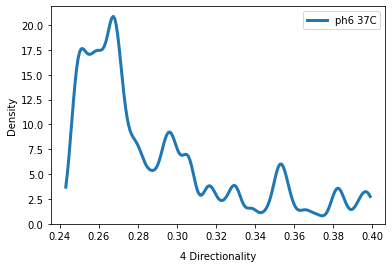

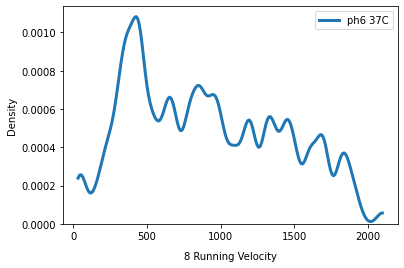

In [ ]:

name = ["Inst Velocity","Angular Velocity","Path","Displacement","Directionality","Moving Time","Average Velocity","Tumbling Frequency","Running Velocity","Tumbling Angular Vel"]

fig = plt.figure(figsize=(5.0,7))
fig = plt.figure( constrained_layout=True)
t = [4,8]
for i in (t):
    plt.figure()
    sns.kdeplot(train_data_plot[:,i], bw=0.5,bw_adjust=.15, cut=0, label = 'ph6 37C', linewidth=3)
    plt.draw()
    plt.xlabel(str(i)+" "+name[i], labelpad=10)
    plt.legend()
